In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from model_helper import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

main = pd.read_pickle("../clean_main.df")
splitDate = pd.to_datetime("1998-07-19")
main = main.loc[main.date >= splitDate]#[:50000]

No handles with labels found to put in legend.


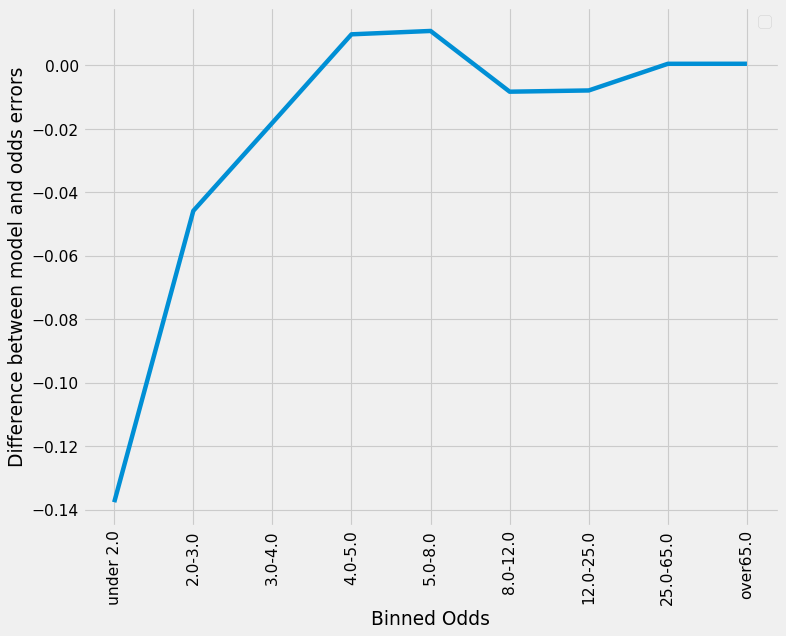

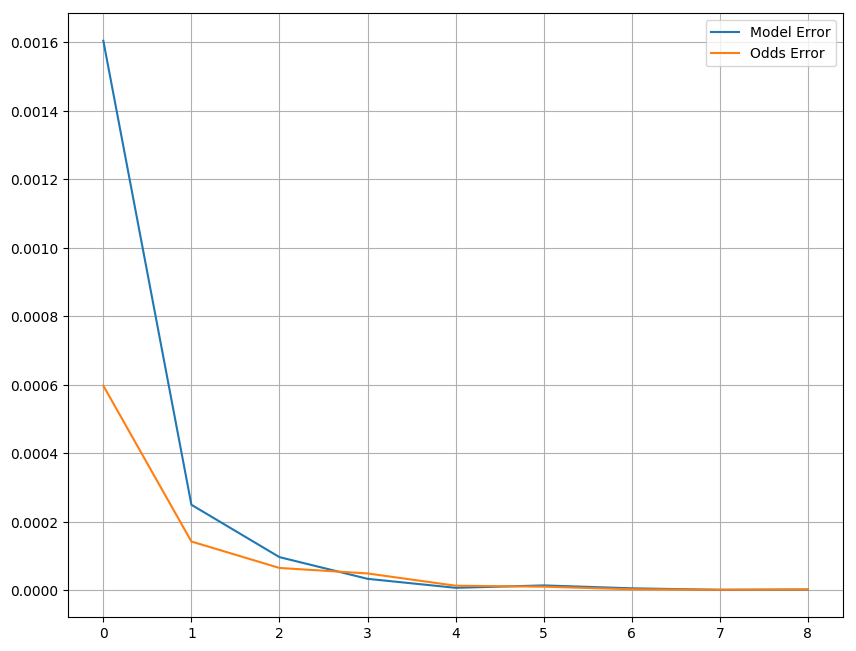

In [27]:
FEATURES = ["gear_change", 
            "horse_rating_rel", "last_speed_rating_rel", "average_speed_rating_rel",
            "best_surface_distance_rel", "weight_rating_rel", 
            "rest_rating_rel", 
            "going_rating_rel",
            "jockey_win_percent_rel", "trainer_win_percent_rel", "horse_win_percent_rel",
            "horse_norm_record_rel", "trainer_norm_record_rel", "jockey_norm_record_rel", 
            "trainer_jockey_record_rel", "draw_win_percent_rel",
            "avg_sec1_speed_rating_rel", "last_sec1_speed_rating_rel",
            "avg_last_sec_speed_rating_rel", "last_last_sec_speed_rating_rel",
            "avg_speed_rating_ratio_rel", "last_speed_rating_ratio_rel", "win_odds"
           ]

TARGET = "won"

#plt.figure(figsize=(10,8), dpi=100) 
cross_val_folds = 5

oddsDiffs = []
modelAcc = []
oddsAcc = []
counts = []
for training, testing in getCrossVal(main, cross_val_folds):
    model = LogisticRegression(max_iter=2000)
    X_train = training[FEATURES]
    y_train = training[TARGET]
    X_test = testing[FEATURES]
    y_test = testing[TARGET]
    
    model.fit(X_train, y_train)
    preds = np.array(model.predict_proba(X_test))
    testing = testing.reset_index()
    
    # Bin the testing data: Look at different odds groups to see if my model outperforms in any
    bin0 = testing.loc[testing.win_odds <= 2.0]
    bin1 = testing.loc[(testing.win_odds > 2.0) & (testing.win_odds <= 3.0)]
    bin2 = testing.loc[(testing.win_odds > 3.0) & (testing.win_odds <= 4.0)]
    bin3 = testing.loc[(testing.win_odds > 4.0) & (testing.win_odds <= 5.0)]
    bin4 = testing.loc[(testing.win_odds > 5.0) & (testing.win_odds <= 8.0)]
    bin5 = testing.loc[(testing.win_odds > 8.0) & (testing.win_odds <= 12.0)]
    bin6 = testing.loc[(testing.win_odds > 12.0) & (testing.win_odds <= 25.0)]
    bin7 = testing.loc[(testing.win_odds > 25.0) & (testing.win_odds <= 60.0)]
    bin8 = testing.loc[testing.win_odds > 60.0]
    bins = [bin0, bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8]
    
    avgOdds = [b.win_odds.mean() for b in bins]
    impProb = [avgOdd**-1 for avgOdd in avgOdds]
    actualWinPct = [b.won.mean() for b in bins]
    
    # See what my model predicts on these bins
    binPreds = [preds[np.array(b.index)] for b in bins]
    binPreds = [[i for _, i in arr] for arr in binPreds]
    predsProbs = [np.mean(b) for b in binPreds]
    
    oddsDiff = [np.abs(impProb[i]-actualWinPct[i]) for i in range(len(bins))]
    predsDiff = [np.abs(predsProbs[i]-actualWinPct[i]) for i in range(len(bins))]
    
    ROI_pct = np.array(actualWinPct) / np.array(impProb) - 1
    
    odds_vs_preds = np.array(oddsDiff) - np.array(predsDiff)
    
    # Display the results
    df = pd.DataFrame()
    df["counts"] = [len(b) for b in bins]
    #df["avg_odds"] = avgOdds
    #df["imp_prob"] = impProb
    #df["win_pct"] = actualWinPct
    #df["pred_prob"] = predsProbs
    #df["odds_diff"] = oddsDiff
    #df["model_diff"] = predsDiff
    df["odds_vs_model"] = odds_vs_preds # Positive is good
    #print(df)
    oddsDiffs.append(odds_vs_preds)
    #oddsDiffs.append(ROI_pct)
    counts.append([len(b) for b in bins])
    modelAcc.append(predsDiff)
    oddsAcc.append(oddsDiff)
    
avgs = []
modelAvgs = []
oddsAvgs = []
for i in range(len(oddsDiffs[0])):
    avg = 0
    modelAvg = 0
    oddsAvg = 0
    countCount = 0 
    for j in range(len(oddsDiffs)):
        val = oddsDiffs[j][i]
        count = counts[j][i]
        avg += val * count
        countCount += count
        
        modelAvg += modelAcc[j][i]
        oddsAvg += oddsAcc[j][i]
        
    avgs.append(avg/countCount)
    modelAvgs.append(modelAvg/countCount)
    oddsAvgs.append(oddsAvg/countCount)
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10,8), dpi=80)
    plt.plot(avgs)
    plt.xlabel("Binned Odds")
    plt.ylabel("Difference between model and odds errors")
    plt.xticks(range(len(avgs)), ("under 2.0", "2.0-3.0", "3.0-4.0", "4.0-5.0", "5.0-8.0", "8.0-12.0", "12.0-25.0", "25.0-65.0", "over65.0"), rotation=90)

    #plt.grid()
    plt.legend()
plt.figure(figsize=(10,8), dpi=100)
plt.plot(modelAvgs, label="Model Error")
plt.plot(oddsAvgs, label="Odds Error")
plt.grid()
plt.legend()

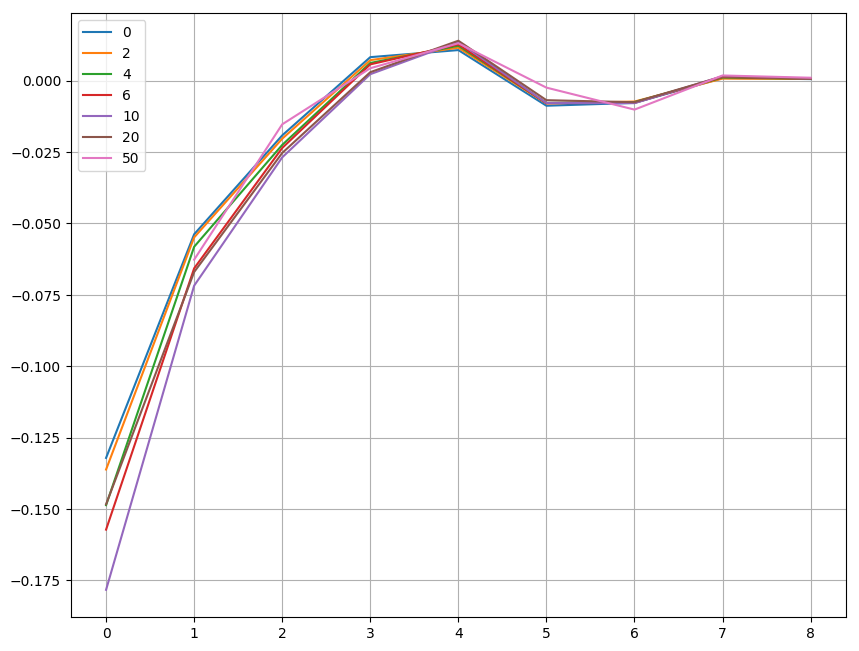

In [10]:
plt.figure(figsize=(10,8), dpi=100) 
NUM_OF_RACES = [0, 2, 4, 6, 10, 20, 50]
for n in NUM_OF_RACES:
    cross_val_folds = 2
    oddsDiffs = []
    counts = []
    for training, testing in getCrossVal(main, cross_val_folds):
        model = LogisticRegression(max_iter=2000)
        X_train = training[FEATURES]
        y_train = training[TARGET]
        X_test = testing[FEATURES]
        y_test = testing[TARGET]

        model.fit(X_train, y_train)
        preds = pd.DataFrame({"preds":[i for _, i in model.predict_proba(X_test)]})
        testing = testing.reset_index()

        # Bin the testing data: Look at different odds groups to see if my model outperforms in any
        bin1 = testing.loc[testing.win_odds <= 2.0]
        bin2 = testing.loc[(testing.win_odds > 2.0) & (testing.win_odds <= 3.0)]
        bin3 = testing.loc[(testing.win_odds > 3.0) & (testing.win_odds <= 4.0)]
        bin4 = testing.loc[(testing.win_odds > 4.0) & (testing.win_odds <= 5.0)]
        bin5 = testing.loc[(testing.win_odds > 5.0) & (testing.win_odds <= 8.0)]
        bin6 = testing.loc[(testing.win_odds > 8.0) & (testing.win_odds <= 12.0)]
        bin7 = testing.loc[(testing.win_odds > 12.0) & (testing.win_odds <= 25.0)]
        bin8 = testing.loc[(testing.win_odds > 25.0) & (testing.win_odds <= 60.0)]
        bin9 = testing.loc[testing.win_odds > 60.0]
        bins = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]

        avgOdds = [b.win_odds.mean() for b in bins]
        impProb = [avgOdd**-1 for avgOdd in avgOdds]
        actualWinPct = [b.won.mean() for b in bins]

        reducedBins = [b.loc[b.num_of_races>=n] for b in bins]

        # See what my model predicts on these bins
        binPreds = [preds.loc[preds.index.isin(b.index)] for b in reducedBins]
        predsProbs = [b.mean() for b in binPreds]

        oddsDiff = [np.abs(impProb[i]-actualWinPct[i]) for i in range(len(bins))]
        predsDiff = [np.abs(predsProbs[i].values[0]-actualWinPct[i]) for i in range(len(bins))]

        odds_vs_preds = np.array(oddsDiff) - np.array(predsDiff)

        # Display the results
        df = pd.DataFrame()
        df["counts"] = [len(b) for b in binPreds]
        #df["avg_odds"] = avgOdds
        #df["imp_prob"] = impProb
        #df["win_pct"] = actualWinPct
        #df["pred_prob"] = predsProbs
        #df["odds_diff"] = oddsDiff
        #df["model_diff"] = predsDiff
        df["odds_vs_model"] = odds_vs_preds # Positive is good
        #print(df)
        oddsDiffs.append(odds_vs_preds)
        counts.append([len(b) for b in binPreds])

    avgs = []
    for i in range(len(oddsDiffs[0])):
        avg = 0
        countCount = 0 
        for j in range(len(oddsDiffs)):
            val = oddsDiffs[j][i]
            count = counts[j][i]
            avg += val * count
            countCount += count

        avgs.append(avg/countCount)
    plt.plot(avgs, label=n)
    plt.grid()
    plt.legend()

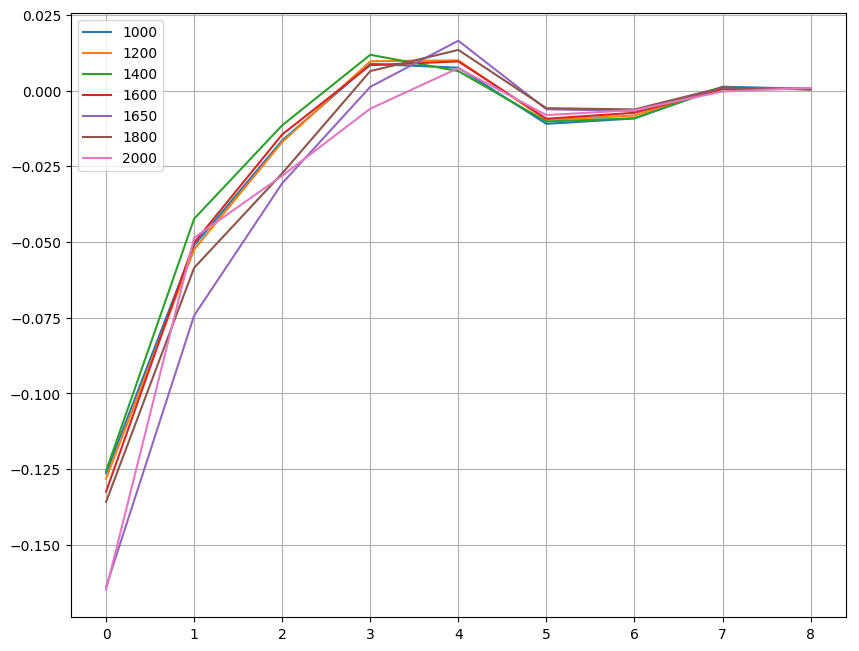

In [11]:
plt.figure(figsize=(10,8), dpi=100)
var = "distance"
temps = np.unique(main[var])
for t in temps:
    cross_val_folds = 2
    oddsDiffs = []
    counts = []
    for training, testing in getCrossVal(main, cross_val_folds):
        model = LogisticRegression(max_iter=2000)
        X_train = training[FEATURES]
        y_train = training[TARGET]
        X_test = testing[FEATURES]
        y_test = testing[TARGET]

        model.fit(X_train, y_train)
        preds = pd.DataFrame({"preds":[i for _, i in model.predict_proba(X_test)]})
        testing = testing.reset_index()

        # Bin the testing data: Look at different odds groups to see if my model outperforms in any
        bin1 = testing.loc[testing.win_odds <= 2.0]
        bin2 = testing.loc[(testing.win_odds > 2.0) & (testing.win_odds <= 3.0)]
        bin3 = testing.loc[(testing.win_odds > 3.0) & (testing.win_odds <= 4.0)]
        bin4 = testing.loc[(testing.win_odds > 4.0) & (testing.win_odds <= 5.0)]
        bin5 = testing.loc[(testing.win_odds > 5.0) & (testing.win_odds <= 8.0)]
        bin6 = testing.loc[(testing.win_odds > 8.0) & (testing.win_odds <= 12.0)]
        bin7 = testing.loc[(testing.win_odds > 12.0) & (testing.win_odds <= 25.0)]
        bin8 = testing.loc[(testing.win_odds > 25.0) & (testing.win_odds <= 60.0)]
        bin9 = testing.loc[testing.win_odds > 60.0]
        bins = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]

        avgOdds = [b.win_odds.mean() for b in bins]
        impProb = [avgOdd**-1 for avgOdd in avgOdds]
        actualWinPct = [b.won.mean() for b in bins]

        reducedBins = [b.loc[b[var] == t] for b in bins]

        # See what my model predicts on these bins
        binPreds = [preds.loc[preds.index.isin(b.index)] for b in reducedBins]
        predsProbs = [b.mean() for b in binPreds]

        oddsDiff = [np.abs(impProb[i]-actualWinPct[i]) for i in range(len(bins))]
        predsDiff = [np.abs(predsProbs[i].values[0]-actualWinPct[i]) for i in range(len(bins))]

        odds_vs_preds = np.array(oddsDiff) - np.array(predsDiff)

        # Display the results
        df = pd.DataFrame()
        df["counts"] = [len(b) for b in binPreds]
        #df["avg_odds"] = avgOdds
        #df["imp_prob"] = impProb
        #df["win_pct"] = actualWinPct
        #df["pred_prob"] = predsProbs
        #df["odds_diff"] = oddsDiff
        #df["model_diff"] = predsDiff
        df["odds_vs_model"] = odds_vs_preds # Positive is good
        #print(df)
        oddsDiffs.append(odds_vs_preds)
        counts.append([len(b) for b in binPreds])

    avgs = []
    for i in range(len(oddsDiffs[0])):
        avg = 0
        countCount = 0 
        for j in range(len(oddsDiffs)):
            val = oddsDiffs[j][i]
            count = counts[j][i]
            avg += val * count
            countCount += count

        avgs.append(avg/countCount)
    plt.plot(avgs, label=t)
    plt.grid()
    plt.legend()

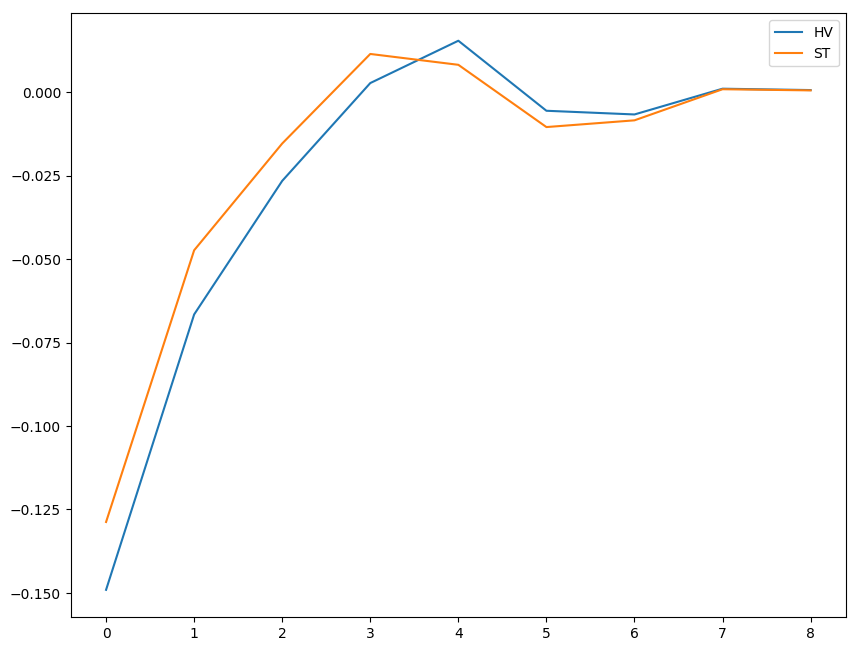

In [12]:
plt.figure(figsize=(10,8), dpi=100)
var = "venue"
temps = np.unique(main[var])
for t in temps:
    cross_val_folds = 2
    oddsDiffs = []
    counts = []
    for training, testing in getCrossVal(main, cross_val_folds):
        model = LogisticRegression(max_iter=2000)
        X_train = training[FEATURES]
        y_train = training[TARGET]
        X_test = testing[FEATURES]
        y_test = testing[TARGET]

        model.fit(X_train, y_train)
        preds = pd.DataFrame({"preds":[i for _, i in model.predict_proba(X_test)]})
        testing = testing.reset_index()

        # Bin the testing data: Look at different odds groups to see if my model outperforms in any
        bin1 = testing.loc[testing.win_odds <= 2.0]
        bin2 = testing.loc[(testing.win_odds > 2.0) & (testing.win_odds <= 3.0)]
        bin3 = testing.loc[(testing.win_odds > 3.0) & (testing.win_odds <= 4.0)]
        bin4 = testing.loc[(testing.win_odds > 4.0) & (testing.win_odds <= 5.0)]
        bin5 = testing.loc[(testing.win_odds > 5.0) & (testing.win_odds <= 8.0)]
        bin6 = testing.loc[(testing.win_odds > 8.0) & (testing.win_odds <= 12.0)]
        bin7 = testing.loc[(testing.win_odds > 12.0) & (testing.win_odds <= 25.0)]
        bin8 = testing.loc[(testing.win_odds > 25.0) & (testing.win_odds <= 60.0)]
        bin9 = testing.loc[testing.win_odds > 60.0]
        bins = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]

        avgOdds = [b.win_odds.mean() for b in bins]
        impProb = [avgOdd**-1 for avgOdd in avgOdds]
        actualWinPct = [b.won.mean() for b in bins]

        reducedBins = [b.loc[b[var] == t] for b in bins]

        # See what my model predicts on these bins
        binPreds = [preds.loc[preds.index.isin(b.index)] for b in reducedBins]
        predsProbs = [b.mean() for b in binPreds]

        oddsDiff = [np.abs(impProb[i]-actualWinPct[i]) for i in range(len(bins))]
        predsDiff = [np.abs(predsProbs[i].values[0]-actualWinPct[i]) for i in range(len(bins))]

        odds_vs_preds = np.array(oddsDiff) - np.array(predsDiff)

        # Display the results
        df = pd.DataFrame()
        df["counts"] = [len(b) for b in binPreds]
        #df["avg_odds"] = avgOdds
        #df["imp_prob"] = impProb
        #df["win_pct"] = actualWinPct
        #df["pred_prob"] = predsProbs
        #df["odds_diff"] = oddsDiff
        #df["model_diff"] = predsDiff
        df["odds_vs_model"] = odds_vs_preds # Positive is good
        #print(df)
        oddsDiffs.append(odds_vs_preds)
        counts.append([len(b) for b in binPreds])

    avgs = []
    for i in range(len(oddsDiffs[0])):
        avg = 0
        countCount = 0 
        for j in range(len(oddsDiffs)):
            val = oddsDiffs[j][i]
            count = counts[j][i]
            avg += val * count
            countCount += count

        avgs.append(avg/countCount)
    plt.plot(avgs, label=t)
    plt.grid()
    plt.legend()

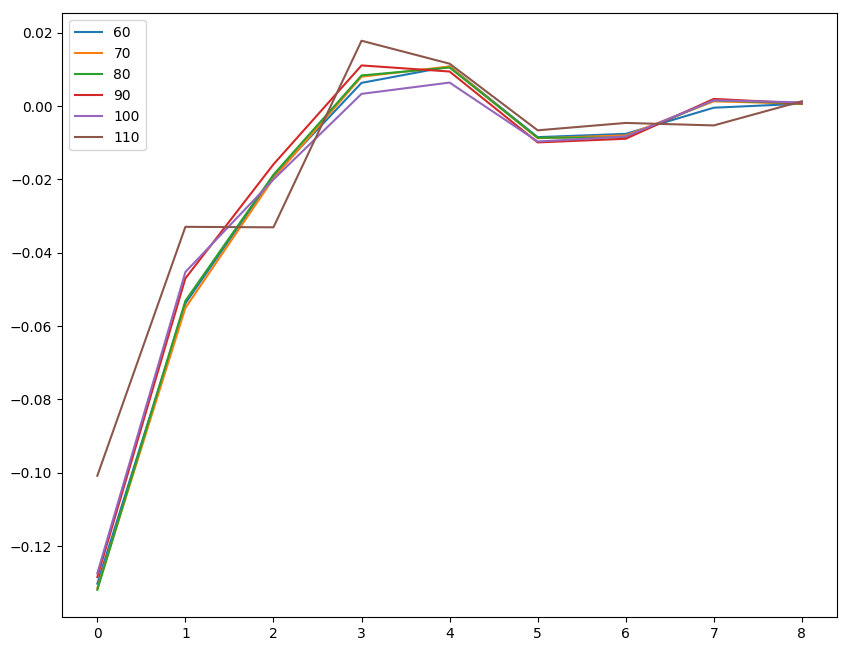

In [13]:
plt.figure(figsize=(10,8), dpi=100)
var = "speed_rating"
temps = [60, 70, 80, 90, 100, 110]
for t in temps:
    cross_val_folds = 2
    oddsDiffs = []
    counts = []
    for training, testing in getCrossVal(main, cross_val_folds):
        model = LogisticRegression(max_iter=2000)
        X_train = training[FEATURES]
        y_train = training[TARGET]
        X_test = testing[FEATURES]
        y_test = testing[TARGET]

        model.fit(X_train, y_train)
        preds = pd.DataFrame({"preds":[i for _, i in model.predict_proba(X_test)]})
        testing = testing.reset_index()

        # Bin the testing data: Look at different odds groups to see if my model outperforms in any
        bin1 = testing.loc[testing.win_odds <= 2.0]
        bin2 = testing.loc[(testing.win_odds > 2.0) & (testing.win_odds <= 3.0)]
        bin3 = testing.loc[(testing.win_odds > 3.0) & (testing.win_odds <= 4.0)]
        bin4 = testing.loc[(testing.win_odds > 4.0) & (testing.win_odds <= 5.0)]
        bin5 = testing.loc[(testing.win_odds > 5.0) & (testing.win_odds <= 8.0)]
        bin6 = testing.loc[(testing.win_odds > 8.0) & (testing.win_odds <= 12.0)]
        bin7 = testing.loc[(testing.win_odds > 12.0) & (testing.win_odds <= 25.0)]
        bin8 = testing.loc[(testing.win_odds > 25.0) & (testing.win_odds <= 60.0)]
        bin9 = testing.loc[testing.win_odds > 60.0]
        bins = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9]

        avgOdds = [b.win_odds.mean() for b in bins]
        impProb = [avgOdd**-1 for avgOdd in avgOdds]
        actualWinPct = [b.won.mean() for b in bins]

        reducedBins = [b.loc[b[var] >= t] for b in bins]

        # See what my model predicts on these bins
        binPreds = [preds.loc[preds.index.isin(b.index)] for b in reducedBins]
        predsProbs = [b.mean() for b in binPreds]

        oddsDiff = [np.abs(impProb[i]-actualWinPct[i]) for i in range(len(bins))]
        predsDiff = [np.abs(predsProbs[i].values[0]-actualWinPct[i]) for i in range(len(bins))]

        odds_vs_preds = np.array(oddsDiff) - np.array(predsDiff)

        # Display the results
        df = pd.DataFrame()
        df["counts"] = [len(b) for b in binPreds]
        #df["avg_odds"] = avgOdds
        #df["imp_prob"] = impProb
        #df["win_pct"] = actualWinPct
        #df["pred_prob"] = predsProbs
        #df["odds_diff"] = oddsDiff
        #df["model_diff"] = predsDiff
        df["odds_vs_model"] = odds_vs_preds # Positive is good
        #print(df)
        oddsDiffs.append(odds_vs_preds)
        counts.append([len(b) for b in binPreds])

    avgs = []
    for i in range(len(oddsDiffs[0])):
        avg = 0
        countCount = 0 
        for j in range(len(oddsDiffs)):
            val = oddsDiffs[j][i]
            count = counts[j][i]
            avg += val * count
            countCount += count

        avgs.append(avg/countCount)
    plt.plot(avgs, label=t)
    plt.grid()
    plt.legend()

AttributeError: module 'numpy' has no attribute 'arrange'